<a href="https://colab.research.google.com/github/ToanToan110/CustomerLifeTimeValue/blob/main/CustomerLifeTimeValue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Overview***
**Customer Life Time Value (CLV):** Giá trị mà khách hàng mang lại trong suốt khoảng thời gian họ hoạt động.
Xác định đâu là đối tượng khách hàng đáng để đầu tư và khai thác.

Doanh nghiệp cần tính toán được chỉ số CLV để xác định được đâu là nhóm khách hàng mang lại giá trị cao.

=> Đưa ra các chiến lược tiếp thị phù hợp để tối ưu hóa lợi nhuận và chi phí bỏ ra
# ***Nội dung notebook***
 - Output: xác định đâu là nhóm khách hàng mang lại giá trị (CLV cao)
 - Đưa ra các kĩ thuật xác định và phân nhóm CLV, lựa chọn mô hình máy học phù hợp để phân loại nhóm high-CLV.

# I. Chuẩn bị dữ liệu:

In [ ]:
import pandas as pd
import numpy as np
import plotly.offline as pyoff
import plotly.graph_objs as go
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from datetime import timedelta
import lifetimes

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data Driven Growth Series/OnlineRetail.csv", encoding='ISO-8859-1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
tx_data = df.copy()
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
tx_data['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'].dt.strftime('%Y-%m-%d'))
tx_uk = tx_data.query("Country=='United Kingdom'").reset_index(drop=True)
tx_uk.dropna(subset='CustomerID', inplace = True)
tx_uk.info()

<class 'pandas.core.frame.DataFrame'>
Index: 361878 entries, 0 to 495477
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    361878 non-null  object        
 1   StockCode    361878 non-null  object        
 2   Description  361878 non-null  object        
 3   Quantity     361878 non-null  int64         
 4   InvoiceDate  361878 non-null  datetime64[ns]
 5   UnitPrice    361878 non-null  float64       
 6   CustomerID   361878 non-null  float64       
 7   Country      361878 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 24.8+ MB


---
**Đến đây có hai hướng tiếp cận để tính toán CLV:**


1.   Tính toán dựa trên một khoảng thời gian cụ thể trên bộ dữ liệu
2.   Tính toán dự trên công thức:

          CTV = Avg Revenue * N_month * Rt_rate


Trong đó:
- Avg Revenue: Average monthly purchase made by the customer in the active customer window.
- N_month : Number of months in the CLV prediction period
- Rt_rate : Overall retention rate of all customers
---




# II. Approach 1: Dựa trên dữ liệu lịch sử:
Doanh thu trong giai đoạn 3 tháng từ tháng 9 đến tháng 12 sẽ được sử dụng làm CLV cho data trong giai đoạn từ tháng 1 đến tháng 6.

 **=> Chia tập dữ liệu thành 2 phần:**
- Phần I: tập dữ liệu của 6 tháng từ 1/3/2011 đến 31/8/2011
- Phần II: tập dữ liệu của 3 tháng từ 1/9/2011 đến 30/11/2011

Doanh thu của phần II sẽ là CTV cho phần I và sẽ được sử dụng để đào tạo mô hình.

In [ ]:
# @title Tính toán RFM
#create tx_user for assigning clustering
def GetRFM(tx_uk):
  tx_user = pd.DataFrame(tx_uk['CustomerID'].unique())
  tx_user.columns = ['CustomerID']

  #calculate recency score
  tx_max_purchase = tx_uk.groupby('CustomerID').InvoiceDate.max().reset_index()
  tx_max_purchase.columns = ['CustomerID','MaxPurchaseDate']
  tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days
  tx_user = pd.merge(tx_user, tx_max_purchase[['CustomerID','Recency']], on='CustomerID')

  #calcuate frequency score
  tx_frequency = tx_uk.groupby('CustomerID').InvoiceDate.count().reset_index()
  tx_frequency.columns = ['CustomerID','Frequency']
  tx_user = pd.merge(tx_user, tx_frequency, on='CustomerID')

  #calcuate revenue score
  tx_uk['Revenue'] = tx_uk['UnitPrice'] * tx_uk['Quantity']
  tx_revenue = tx_uk.groupby('CustomerID').Revenue.sum().reset_index()
  tx_user = pd.merge(tx_user, tx_revenue, on='CustomerID')

  return tx_user

In [ ]:
# @title Xác định CLV theo hướng 1:
#create 3m and 6m dataframes
tx_uk['Revenue'] = tx_uk['UnitPrice'] * tx_uk['Quantity']
tx_6m = tx_uk[(tx_uk.InvoiceDate < "2011-09-01")].reset_index(drop=True)
tx_6m = GetRFM(tx_6m)

tx_3m = tx_uk[(tx_uk.InvoiceDate >= "2011-09-01")].reset_index(drop=True)
tx_3m = GetRFM(tx_3m)
# Create df_train
df_train = pd.merge(tx_6m, tx_3m[['CustomerID','Revenue']], on = 'CustomerID')
df_train.rename(columns = {'Revenue_x':"Revenue", 'Revenue_y':"CLV"}, inplace = True)
df_train.head()

,CustomerID,Recency,Frequency,Revenue,CLV
0,13047.0,13,159,2559.42,519.68
1,13748.0,132,13,580.85,367.40
2,15291.0,72,89,3234.48,1362.03
3,14688.0,29,247,3833.45,1273.93
4,17809.0,29,37,2138.42,2489.20


In [ ]:
# @title Xác định CLV theo hướng 2:
# CTV = Avg Revenue * N_month * Rt_rate
# Average monthly purchase made by the customer in the active customer window.
# Number of months in the CLV prediction period

tx_user_purchase = tx_uk.copy()
tx_user_purchase['InvoiceDatetime'] = pd.to_datetime(tx_user_purchase['InvoiceDate'])
tx_user_purchase['InvoiceMonth'] = tx_user_purchase['InvoiceDatetime'].map(lambda date: 100*date.year + date.month)
#identify which users are active by looking at their revenue per month
tx_user_purchase = tx_user_purchase.groupby(['CustomerID','InvoiceMonth'])['Revenue'].sum().reset_index()
#create retention matrix with crosstab
tx_retention = pd.crosstab(tx_user_purchase['CustomerID'], tx_user_purchase['InvoiceMonth']).reset_index()
tx_retention.head()

InvoiceMonth,CustomerID,201012,201101,201102,201103,201104,201105,201106,201107,201108,201109,201110,201111,201112
0,12346.0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,12747.0,1,1,0,1,0,1,1,0,1,0,1,1,1
2,12748.0,1,1,1,1,1,1,1,1,1,1,1,1,1
3,12749.0,0,0,0,0,0,1,0,0,1,0,0,1,1
4,12820.0,0,1,0,0,0,0,0,0,0,1,1,0,1


In [ ]:
months = tx_retention.columns[2:]
TotalUserCount = 0
RetainedUserCount = 0
for i in range(len(months)-1):
    selected_month = months[i+1]
    prev_month = months[i]
    # retention_data['InvoiceYearMonth'] = int(selected_month)
    TotalUserCount = TotalUserCount + tx_retention[selected_month].sum()
    RetainedUserCount = RetainedUserCount +  tx_retention[(tx_retention[selected_month]>0) & (tx_retention[prev_month]>0)][selected_month].sum()
rtt_rate = RetainedUserCount/TotalUserCount
rtt_rate

0.40566125290023203

In [ ]:
df_train2 = GetRFM(tx_uk)
df_train2['CLV'] = df_train2['Revenue']*rtt_rate
df_train2.head()

,CustomerID,Recency,Frequency,Revenue,CLV
0,17850.0,302,312,5288.63,2145.392272
1,13047.0,31,196,3079.10,1249.071564
2,13748.0,95,28,948.25,384.668283
3,15100.0,330,6,635.10,257.635462
4,15291.0,25,109,4596.51,1864.626006


Logic xác định nhóm high-value CLV:

- Nhóm khách hàng tạo nên 80% doanh thu cho công ty

In [ ]:
# @title Xác định nhóm high-value CLV
def getclvsegment(df_train):
  df_train.sort_values(by='CLV', ascending = False, inplace=True, ignore_index = True)
  df_train['cumsumCLV'] = df_train['CLV'].cumsum()
  df_train['CLVSegment'] = 0 ## 0 is normal-value CLV
  df_train.loc[df_train['cumsumCLV'] <= df_train['CLV'].sum()*0.8, 'CLVSegment'] = 1 ## 1 is high-value CLV
  # df_train['CLVSegment'].mean()
  return df_train
df_train = getclvsegment(df_train)
df_train2 = getclvsegment(df_train2)

In [ ]:
print(df_train2['CLVSegment'].mean())
print(df_train['CLVSegment'].mean())

0.2827848101265823
0.34024663677130046


=> 34% Customer Create 80% Value for bussiness. That's so cool!

But the percentage of high life time value in approach 2 is less than approach 1!

## II.3. Đào tạo mô hình theo hướng 1:

In [ ]:
#import machine learning related libraries
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [ ]:
x = df_train[['Recency', 'Frequency', 'Revenue']]
y = df_train['CLVSegment']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)

x2 = df_train2[['Recency', 'Frequency', 'Revenue']]
y2 = df_train2['CLVSegment']
x_train2, x_test2, y_train2, y_test2 = train_test_split(x, y, test_size = 0.3, random_state = 0)

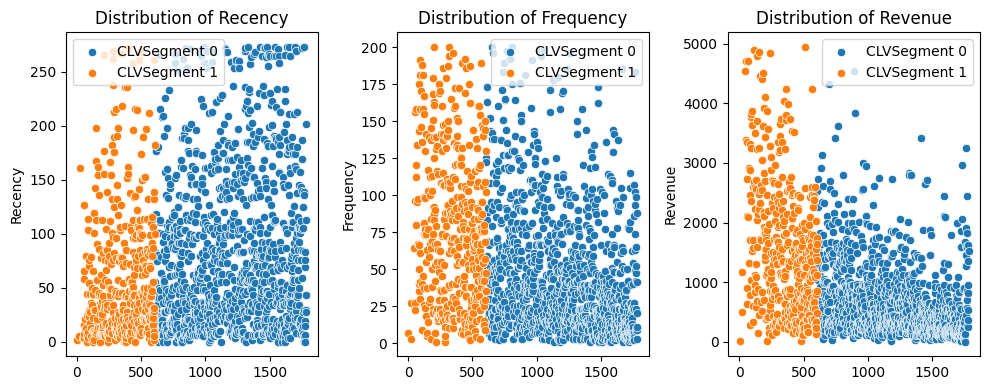

In [ ]:
# @title Phân bổ tập dữ liệu

# sns.pairplot(data=df_train[['Recency', 'Frequency', 'Revenue', 'CLVSegment']], hue = 'CLVSegment')
fre_cond = df_train['Frequency'] <=200
rev_cond = (df_train['Revenue'] <=5000) & (df_train['Revenue'] > 0)
data=df_train.loc[fre_cond & rev_cond, ['Recency', 'Frequency', 'Revenue', 'CLVSegment']]

# Plot distributions of each feature
f, axes = plt.subplots(1, 3, figsize=(10,4))

for i, col in enumerate(['Recency', 'Frequency', 'Revenue']):
    sns.scatterplot(data[data['CLVSegment']==0][col], ax=axes[i], label='CLVSegment 0')
    sns.scatterplot(data[data['CLVSegment']==1][col], ax=axes[i], label='CLVSegment 1')
    axes[i].set_title('Distribution of '+col)
    axes[i].legend()

plt.tight_layout()
plt.show()

=> Tập dữ liệu chưa thể hiện được sự phân bổ đặc biệt nào

=> Let's try a lot of familiar model

In [ ]:
#create an array of models
models = []
models.append(("LR",LogisticRegression()))
models.append(("NB",GaussianNB()))
models.append(("RF",RandomForestClassifier()))
models.append(("SVC",SVC()))
models.append(("Dtree",DecisionTreeClassifier()))
models.append(("XGB",xgb.XGBClassifier()))
models.append(("KNN",KNeighborsClassifier()))
df_score = pd.DataFrame()
#measure the accuracy
for name,model in models:
    kfold = KFold(n_splits=3)
    cv_result = cross_val_score(model,x_train,y_train, cv = kfold, scoring = "accuracy")
    # Create a series
    result_series = pd.Series(cv_result, name=name)

    # Concat the series
    df_score = pd.concat([df_score, result_series], axis=1)
df_score

,LR,NB,RF,SVC,Dtree,XGB,KNN
0,0.798077,0.771635,0.776442,0.788462,0.704327,0.752404,0.781250
1,0.764423,0.750000,0.766827,0.759615,0.685096,0.725962,0.737981
2,0.802885,0.776442,0.786058,0.786058,0.685096,0.752404,0.752404


=> XGBOOST mang lại tính ổn định cao trên các tập data khác nhau

Linear Regression mang lại tính chính xác cao nhưng kém ổn định hơn

In [ ]:
# @title Run model
xgb_model = xgb.XGBClassifier().fit(x_train, y_train)
print('Accuracy of XGB classifier on training set: {:.4f}'
       .format(xgb_model.score(x_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.4f}'
       .format(xgb_model.score(x_test[x_train.columns], y_test)))

Accuracy of XGB classifier on training set: 0.9800
Accuracy of XGB classifier on test set: 0.7239


XGBOOST có nhiều tham số, trong ví dụ này ta sẽ tinh chỉnh tham số max_depth, và

In [ ]:
from sklearn.model_selection import GridSearchCV
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(),
                        param_grid = param_test1, scoring='accuracy', n_jobs=-1, cv=2)
gsearch1.fit(x_train,y_train)
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 4, 'min_child_weight': 3}, 0.766025641025641)

In [ ]:
# @title Cải thiện mô hình
xgb_model = xgb.XGBClassifier(max_depth= 3, min_child_weight= 1).fit(x_train, y_train)
print('Accuracy of XGB classifier on training set: {:.4f}'
       .format(xgb_model.score(x_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.4f}'
       .format(xgb_model.score(x_test[x_train.columns], y_test)))

Accuracy of XGB classifier on training set: 0.8686
Accuracy of XGB classifier on test set: 0.7575


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred = xgb_model.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Tạo báo cáo phân loại
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

Confusion Matrix:
[[302  40]
 [ 90 104]]
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.88      0.82       342
           1       0.72      0.54      0.62       194

    accuracy                           0.76       536
   macro avg       0.75      0.71      0.72       536
weighted avg       0.75      0.76      0.75       536



In [ ]:
# Định nghĩa tham số cần tìm kiếm
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 300]
}

# Tạo đối tượng GridSearchCV
grid_search = GridSearchCV(
    LogisticRegression(),
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,  # Sử dụng 5-fold cross-validation
    n_jobs=-1,  # Sử dụng tất cả các CPU
    verbose=1,  # In ra quá trình tìm kiếm
)

# Đưa dữ liệu huấn luyện vào GridSearchCV
grid_search.fit(x_train, y_train)

# Lấy tham số tốt nhất
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Lấy mô hình tốt nhất
best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Tạo báo cáo phân loại
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best Parameters: {'C': 1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Confusion Matrix:
[[321  21]
 [105  89]]
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.94      0.84       342
           1       0.81      0.46      0.59       194

    accuracy                           0.76       536
   macro avg       0.78      0.70      0.71       536
weighted avg       0.77      0.76      0.75       536



In [ ]:
# Đưa dữ liệu huấn luyện vào GridSearchCV
svc = SVC()
svc.fit(x_train, y_train)

# # Lấy tham số tốt nhất
# best_params = svc.best_params_
# print("Best Parameters:", best_params)

y_pred = svc.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Tạo báo cáo phân loại
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

Confusion Matrix:
[[328  14]
 [114  80]]
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.96      0.84       342
           1       0.85      0.41      0.56       194

    accuracy                           0.76       536
   macro avg       0.80      0.69      0.70       536
weighted avg       0.78      0.76      0.73       536



In [ ]:
df['Revenue'] = df['Quantity'] * df['UnitPrice']

## II.3. Đào tạo mô hình theo hướng 2:

In [ ]:
#import machine learning related libraries
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

In [ ]:
x = df_train[['Recency', 'Frequency', 'Revenue']]
y = df_train['CLVSegment']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)

x2 = df_train2[['Recency', 'Frequency', 'Revenue']]
y2 = df_train2['CLVSegment']
x_train2, x_test2, y_train2, y_test2 = train_test_split(x, y, test_size = 0.3, random_state = 0)

In [ ]:
#create an array of models
models = []
models.append(("LR",LogisticRegression()))
models.append(("NB",GaussianNB()))
models.append(("RF",RandomForestClassifier()))
models.append(("SVC",SVC()))
models.append(("Dtree",DecisionTreeClassifier()))
models.append(("XGB",xgb.XGBClassifier()))
models.append(("KNN",KNeighborsClassifier()))
df_score = pd.DataFrame()
#measure the accuracy
for name,model in models:
    kfold = KFold(n_splits=3)
    cv_result = cross_val_score(model,x_train2,y_train2, cv = kfold, scoring = "accuracy")
    # Create a series
    result_series = pd.Series(cv_result, name=name)

    # Concat the series
    df_score = pd.concat([df_score, result_series], axis=1)
df_score

,LR,NB,RF,SVC,Dtree,XGB,KNN
0,0.798077,0.771635,0.774038,0.788462,0.701923,0.752404,0.781250
1,0.764423,0.750000,0.742788,0.759615,0.692308,0.725962,0.737981
2,0.802885,0.776442,0.786058,0.786058,0.675481,0.752404,0.752404


=> Logistic mang lại tính ổn định và đính xác chấp nhận được trên các tập test khác nhau

In [ ]:
# @title Đào tạo mô hình Logistic Regression
lr_model = LogisticRegression().fit(x_train2, y_train2)
print('Accuracy of XGB classifier on training set: {:.4f}'
       .format(lr_model.score(x_train2, y_train2)))
print('Accuracy of XGB classifier on test set: {:.4f}'
       .format(lr_model.score(x_test2[x_train2.columns], y_test2)))

from sklearn.metrics import confusion_matrix, classification_report
y_pred2 = lr_model.predict(x_test2)
cm2 = confusion_matrix(y_test2, y_pred2)
print("Confusion Matrix:")
print(cm2)

# Tạo báo cáo phân loại
report2 = classification_report(y_test2, y_pred2)
print("Classification Report:")
print(report2)

Accuracy of XGB classifier on training set: 0.7869
Accuracy of XGB classifier on test set: 0.7631
Confusion Matrix:
[[321  21]
 [106  88]]
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.94      0.83       342
           1       0.81      0.45      0.58       194

    accuracy                           0.76       536
   macro avg       0.78      0.70      0.71       536
weighted avg       0.77      0.76      0.74       536



XGBOOST có nhiều tham số, trong ví dụ này ta sẽ tinh chỉnh tham số max_depth

In [ ]:
# @title Cải thiện mô hình
# Định nghĩa tham số cần tìm kiếm
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 300]
}

# Tạo đối tượng GridSearchCV
grid_search = GridSearchCV(
    LogisticRegression(),
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,  # Sử dụng 5-fold cross-validation
    n_jobs=-1,  # Sử dụng tất cả các CPU
    verbose=1,  # In ra quá trình tìm kiếm
)

# Đưa dữ liệu huấn luyện vào GridSearchCV
grid_search.fit(x_train2, y_train2)

# Lấy tham số tốt nhất
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Lấy mô hình tốt nhất
best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test2)
cm = confusion_matrix(y_test2, y_pred2)
print("Confusion Matrix:")
print(cm)

# Tạo báo cáo phân loại
report = classification_report(y_test2, y_pred2)
print("Classification Report:")
print(report)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best Parameters: {'C': 1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Confusion Matrix:
[[321  21]
 [106  88]]
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.94      0.83       342
           1       0.81      0.45      0.58       194

    accuracy                           0.76       536
   macro avg       0.78      0.70      0.71       536
weighted avg       0.77      0.76      0.74       536



# Kết luận:


1.   Cả hai cách tiếp cận để tính toán CLV đều mang lại kết quả không mấy khác biệt.
2.   Mô hình mang lại kết quả dự đoán tương đối tốt nhưng không thể phát hiện được nhiều giá trị có nhãn là 1 trong tập dữ liệu (Không phát hiện được nhiều khách hàng mang lại giá trị cao).

=> Next step: cần có thêm action cải thiện mô hình như:

*   Giải quyết mất cân bằng dữ liệu
*   Làm giàu dữ liệu



